<img src="../../images/QISKit-c.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*Single-qubit randomized benchmarking*_ 

The latest version of this notebook is available on https://github.com/IBM/qiskit-sdk-py/tree/master/scripts.

For more information about how to use the Quantum Experience, consult the [IBM Quantum Experience tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0), or check out the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).

***
### Contributors
Andrew Cross

## Introduction

Randomized benchmarking is a method for estimating average error rates of quantum operations. In this notebook, we consider the example of single-qubit Clifford benchmarking. Under some reasonable assumptions, this method estimates the average infidelity of a single-qubit Clifford gate. The single-qubit Clifford gates rotate the axes of the Bloch sphere until they point along another axis, and are generated by composing the Pauli gates $X$, $Y$, and $Z$ with sequences of two non-Pauli gates Hadamard $H$ and Phase $S=\mathrm{diag}(1,i)$. A benchmarking sequence is a sequence $U_1$, $U_2$, $\dots$, $U_m$ of these gates, where each gate is chosen at random. Each benchmarking sequence is terminated by $U_m=(U_{m-1}\dots U_2U_1)^\dagger$, the inverse of the first $m-1$ gates, so that the whole sequence ideally does nothing. If there are errors on each gate, and we average many gate sequences of the same and increasing lengths, we expect something called the 'survival probability' to decay exponentially as the sequence length grows. The survival probability is the probability that we observe a zero $|0\rangle$ at the end of the sequence, given that we started in a zero $|0\rangle$ state. The rate of exponential decay is what benchmarking aims to measure.

First, we import some dependencies. The modules imported from Qhelpers, especially srb1, contain the benchmarking details. The last line of code creates an API instance and passes in the API token we got from the Quantum Experience web site.

In [1]:
import sys
if sys.version_info < (3,0):
    raise Exception("Please use Python version 3 or greater.")

import math
import time
import random

import numpy as np
from scipy.optimize import curve_fit

import Qconfig
from IBMQuantumExperience import IBMQuantumExperience

import qhelpers.misc as misc
import qhelpers.srb1 as srb1
from qhelpers.basicplotter import plot_rb_data

api = IBMQuantumExperience.IBMQuantumExperience(Qconfig.APItoken, Qconfig.config)

Next, we set some parameters for our benchmarking experiment, call the helper method to generate the benchmarking QASM sources, and submit those sources to the jobs API. The parameters are as follows:

* **qubit** A qubit index from 0 to 4 specifying which qubit to benchmark.
* **total_length** The total length of each benchmarking sequence
* **step** The starting length and increment for benchmarking sub-sequences. Sub-sequence lengths belong to range(step, total_length + step, step).
* **total_sequences** The total number of random sequences to generate and average over.
* **device** Set this to "simulator" to choose the simulator and "real" to choose the real device.
* **shots** The number of shots to take per sub-sequence.
* **maxCredits** The maximum amount to spend per sequence.

After the jobs are generated, the loop at the bottom calls the jobs API to submit each job. We record the jobid in a list so we can refer to it later.

In [2]:
# Parameters for benchmarking
qubit = 0
total_length = 420
step = 20
total_sequences = 10
device = "real"  # "real" or "simulator"
shots = 250
max_credits = 3 # per job, we run total_sequences jobs

# Generate the QASM source
jobs = srb1.generate_srb1_sequences(total_sequences, total_length, step, qubit)

# Submit each job
jobids = []
for job in jobs:
    jobids.append(api.run_job(job, device, shots, max_credits)['id'])

Our jobs are running now and we need to wait for them to complete. This line waits until all of the jobs have completed (or until a timeout occurs). When the job is complete, the results variable contains all of the output.

In [3]:
results = misc.wait_for_jobs(jobids, api, wait=30, timeout=240)

status = {'RUNNING': 8, 'COMPLETED': 2} (0 seconds)
status = {'RUNNING': 6, 'COMPLETED': 4} (30 seconds)
status = {'RUNNING': 4, 'COMPLETED': 6} (60 seconds)
status = {'RUNNING': 3, 'COMPLETED': 7} (90 seconds)
status = {'RUNNING': 1, 'COMPLETED': 9} (120 seconds)
status = {'COMPLETED': 10} (150 seconds)


Finally, we need to process the results. Processing entails computing the survival probabilities and averaging the results over the total set of sequences. The xdata contains sub-sequence lengths, ydatas contains an array of survival probabilities for each sequence, and yavg contains the array of averaged survivial probabilities. We fit an exponential of the form $f(m) = a\alpha^m + b$ to the averaged data, where $a$, $b$, and $\alpha$ are fitting parameters. Finally, we plot all of the results together and print the fitting parameters. If you run this in the simulator, you should see that there is NO decay because there is no decoherence or error. In this case, the fit may fail because the correct functional form is $f(m)=1$.

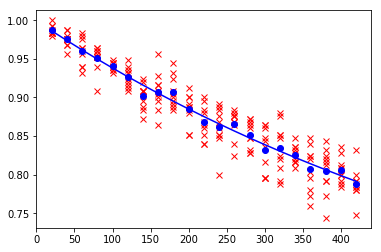

fit parameters = (a=0.46626022889, b=0.532949365793, alpha=0.998596790125)
benchmarking error rate = 0.000702


In [4]:
# Process the results
xdata, ydatas, yavg = srb1.process_results(results, total_sequences, total_length, step, qubit)

# Fit an exponential to the mean survival probability
parameter, cov = curve_fit(srb1.survival_prob, xdata, yavg, p0=(0.5, 0.5, 0.95),
                           bounds=([0, -np.inf, 0], [np.inf, np.inf, 1]))
a = parameter[0]
b = parameter[1]
alpha = parameter[2]
r = (1.0-alpha)/2.0

# Plot the results
plot_rb_data(xdata, ydatas, yavg, parameter, srb1.survival_prob)

# Print the fitting results
print("fit parameters = (a=%s, b=%s, alpha=%s)" % (a, b, alpha))
print("benchmarking error rate = %f" % r)